In [ ]:
# Library
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential,  Model
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate, LeakyReLU, BatchNormalization, Activation
from sklearn.metrics import r2_score, mean_squared_error
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from numpy import savetxt
from keras.layers import Layer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import math

In [ ]:
# Seed
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763/Data')
Data1 = loadmat('p5763_Set1_Inputs.mat')
Data2 = loadmat('p5763_Set1_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),
                         'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),
                       'physics_out':Data2['physics_out'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df = df[['K','V','AE','Amp','SS','TTF','ln_V_V0','physics_out','Time']]
df_AE_inp = df[['AE','AE']]
df_SS = df[['K','V','AE','Amp','SS']]
df_TTF = df[['K','V','AE','Amp','TTF']]
df_SR = df[['K','V','AE','Amp','ln_V_V0']]
df_AE = df[['K','V','AE','Amp','AE']]
df_PhyOut = df[['K','V','AE','Amp','physics_out']]
xdf = df[['K','V','AE','Amp']]
ydf = df[['SS','TTF','ln_V_V0']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
             K      V    AE      Amp
0     5957.24  17.78  2.00  2090.29
1     5960.89  17.79  2.00  2072.79
2     6214.84  17.81  2.00  2078.77
3     4543.97  17.74  2.00  2085.99
4     4554.15  17.76  1.67  2066.37
...       ...    ...   ...      ...
9495  1033.99  16.82  2.00  1720.64
9496  1032.72  16.81  2.00  1742.58
9497  1032.13  16.81  1.67  1732.37
9498  1032.36  16.81  1.67  1693.09
9499  1114.37  16.83  1.50  1704.66

[9500 rows x 4 columns]
Target Data:
         SS   TTF  ln_V_V0
0     6.05  0.00   -11.51
1     6.06  0.00   -11.51
2     6.06  0.00   -11.51
3     6.07  0.00   -11.51
4     6.07  0.00   -11.51
...    ...   ...      ...
9495  5.92  6.55   -11.51
9496  5.92  6.45   -11.51
9497  5.93  6.34   -11.51
9498  5.93  6.23   -11.51
9499  5.94  6.12   -11.51

[9500 rows x 3 columns]


In [ ]:
# Preprocessing (AE_inp)
arr = df_AE_inp.to_numpy()
n_steps = 100
xdf_AE_inp, ydf_AE_inp = create_timesteps(arr, n_steps)

# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 100
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (TTF)
arr = df_TTF.to_numpy()
n_steps = 100
xdf, ydf_TTF = create_timesteps(arr, n_steps)

# Preprocessing (SR)
arr = df_SR.to_numpy()
n_steps = 100
xdf, ydf_SR = create_timesteps(arr, n_steps)

# Preprocessing (AE)
arr = df_AE.to_numpy()
n_steps = 100
xdf, ydf_AE = create_timesteps(arr, n_steps)

# Preprocessing (Physics_Out)
arr = df_PhyOut.to_numpy()
n_steps = 100
xdf, phy_outdf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (TTF), Y = ', np.shape(ydf_TTF))
print('Target shape (SR), Y = ', np.shape(ydf_SR))
print('Target shape (AE), Y = ', np.shape(ydf_AE))
print('Target shape (Physics_Out), Y = ', np.shape(phy_outdf))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

# Reshape AE
in_dim = xdf_AE_inp.shape[1]*xdf_AE_inp.shape[2]
xdf_AE_inp = xdf_AE_inp.reshape((xdf_AE_inp.shape[0], in_dim))
print('After reshaping, xdf_AE_inp = ', np.shape(xdf_AE_inp))

Features shape, X =  (9400, 100, 4)
Target shape (SS), Y =  (9400,)
Target shape (TTF), Y =  (9400,)
Target shape (SR), Y =  (9400,)
Target shape (AE), Y =  (9400,)
Target shape (Physics_Out), Y =  (9400,)
After reshaping, X =  (9400, 400)
After reshaping, xdf_AE_inp =  (9400, 100)


In [ ]:
# Split into train-val-test (AE_inp)
x_train, x_test, y_train_AE_inp, y_test_AE_inp = train_test_split(xdf, xdf_AE_inp, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_AE_inp, Y_val_AE_inp = train_test_split(x_train, y_train_AE_inp, test_size=0.111, shuffle=False)

# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.111, shuffle=False)

# Split into train-val-test (TTF)
x_train, x_test, y_train_TTF, y_test_TTF = train_test_split(xdf, ydf_TTF, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_TTF, Y_val_TTF = train_test_split(x_train, y_train_TTF, test_size=0.111, shuffle=False)

# Split into train-val-test (SR)
x_train, x_test, y_train_SR, y_test_SR = train_test_split(xdf, ydf_SR, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_SR, Y_val_SR = train_test_split(x_train, y_train_SR, test_size=0.111, shuffle=False)

# Split into train-val-test (AE)
x_train, x_test, y_train_AE, y_test_AE = train_test_split(xdf, ydf_AE, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_AE, Y_val_AE = train_test_split(x_train, y_train_AE, test_size=0.111, shuffle=False)

# Split into train-val-test (Physics Out)
x_train, x_test, y_train_Phy, y_test_Phy = train_test_split(xdf, phy_outdf, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_Phy, Y_val_Phy = train_test_split(x_train, y_train_Phy, test_size=0.111, shuffle=False)

X_train = X_train[6580:7520]
Y_train_SS = Y_train_SS[6580:7520]
Y_train_TTF = Y_train_TTF[6580:7520]
Y_train_SR = Y_train_SR[6580:7520]
Y_train_AE = Y_train_AE[6580:7520]
Y_train_Phy = Y_train_Phy[6580:7520]
Y_train_AE_inp = Y_train_AE_inp[6580:7520]

# Normalize the input
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 940
Validation samples: 940
Testing samples: 940


In [ ]:
# Normalize the input: AE_inp
scaler_ae_inp = MinMaxScaler(feature_range=(0, 1))
Y_train_AE_inp = pd.DataFrame(scaler_ae_inp.fit_transform(Y_train_AE_inp))
Y_val_AE_inp = pd.DataFrame(scaler_ae_inp.transform(Y_val_AE_inp))
y_test_AE_inp = pd.DataFrame(scaler_ae_inp.transform(y_test_AE_inp))

In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler(feature_range=(0, 1))
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: TTF
scaler_ttf = MinMaxScaler(feature_range=(0, 1))
Y_train_TTF = pd.DataFrame(scaler_ttf.fit_transform(Y_train_TTF.reshape(-1, 1)))
Y_val_TTF = pd.DataFrame(scaler_ttf.transform(Y_val_TTF.reshape(-1, 1)))
y_test_TTF = pd.DataFrame(scaler_ttf.transform(y_test_TTF.reshape(-1, 1)))

In [ ]:
# Normalize the output: SR
scaler_sr = MinMaxScaler(feature_range=(-1, 1))
Y_train_SR = pd.DataFrame(scaler_sr.fit_transform(Y_train_SR.reshape(-1, 1)))
Y_val_SR = pd.DataFrame(scaler_sr.transform(Y_val_SR.reshape(-1, 1)))
y_test_SR = pd.DataFrame(scaler_sr.transform(y_test_SR.reshape(-1, 1)))

In [ ]:
# Normalize the output: AE
scaler_ae = MinMaxScaler(feature_range=(0, 1))
Y_train_AE = pd.DataFrame(scaler_ae.fit_transform(Y_train_AE.reshape(-1, 1)))
Y_val_AE = pd.DataFrame(scaler_ae.transform(Y_val_AE.reshape(-1, 1)))
y_test_AE = pd.DataFrame(scaler_ae.transform(y_test_AE.reshape(-1, 1)))

Define Physics-Informed Model: Self Learning Constants

In [ ]:
# Define Physics
class gradient_1(tf.keras.layers.Layer):
  def __init__(self):
    super(gradient_1,self).__init__()
    self.SR = tf.keras.layers.Dense(1)
    self.AE = tf.keras.layers.Dense(1)
    self.all_scale = tf.keras.layers.Dense(1)
    self.c1 = self.add_weight("c1",trainable=True)

  def call(self, params):
    sr_pred, ae = params
    sr_pred = self.SR(sr_pred)
    ae = self.AE(ae)

    term1 = ae
    term2 = self.c1*sr_pred
    eqn = term1-term2
    eqn = self.all_scale(eqn)

    return eqn

In [ ]:
# Define PINN
def MLP_Physics():

  # Define inputs
  X_train = layers.Input(shape=(400),name='X_train')
  ae = layers.Input(shape=(1),name='ae')
  AE =layers.Input(shape=(100),name='AE')

  # Prediction: Shear Stress + TTF
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)

  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  ttf_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  # Prediction: SR
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(AE)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  sr_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  # Model
  grad_out = gradient_1()([sr_pred,ae])
  model = keras.Model(inputs=[X_train,ae,AE],outputs=[ss_pred,ttf_pred,sr_pred,grad_out])
  return model

In [ ]:
# Model Summary
model=MLP_Physics()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 AE (InputLayer)             [(None, 100)]                0         []                            
                                                                                                  
 X_train (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 128)                  12928     ['AE[0][0]']                  
                                                                                                  
 dense (Dense)               (None, 128)                  51328     ['X_train[0][0]']             
                                                                                              

Epoch 1/100
30/30 [==============================] - 5s 26ms/step - loss: 1.7330 - dense_5_loss: 0.3776 - dense_6_loss: 0.2988 - dense_12_loss: 0.9696 - gradient_1_loss: 0.0870 - dense_5_mse: 0.3776 - dense_6_mse: 0.2988 - dense_12_mse: 0.9696 - gradient_1_mse: 0.0870 - val_loss: 1.5029 - val_dense_5_loss: 0.2193 - val_dense_6_loss: 0.2779 - val_dense_12_loss: 0.9327 - val_gradient_1_loss: 0.0730 - val_dense_5_mse: 0.2193 - val_dense_6_mse: 0.2779 - val_dense_12_mse: 0.9327 - val_gradient_1_mse: 0.0730
Epoch 2/100
30/30 [==============================] - 0s 10ms/step - loss: 1.0886 - dense_5_loss: 0.0836 - dense_6_loss: 0.1358 - dense_12_loss: 0.7264 - gradient_1_loss: 0.1428 - dense_5_mse: 0.0836 - dense_6_mse: 0.1358 - dense_12_mse: 0.7264 - gradient_1_mse: 0.1428 - val_loss: 0.8670 - val_dense_5_loss: 0.0859 - val_dense_6_loss: 0.1358 - val_dense_12_loss: 0.3348 - val_gradient_1_loss: 0.3106 - val_dense_5_mse: 0.0859 - val_dense_6_mse: 0.1358 - val_dense_12_mse: 0.3348 - val_gradien

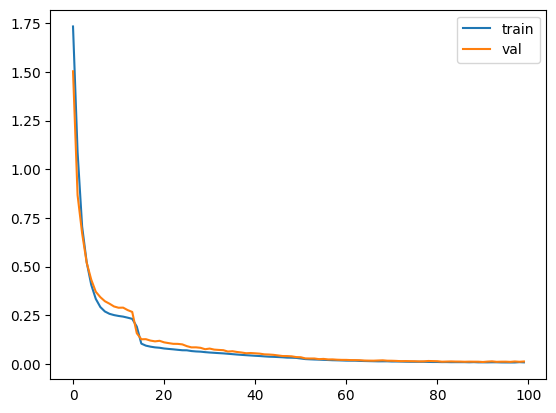

---Training time: 38.83922291 seconds ---


In [ ]:
# Train The Model
start_time = time.time()
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model.fit([X_train,Y_train_AE,Y_train_AE_inp],[Y_train_SS,Y_train_TTF,Y_train_SR,Y_train_Phy], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val,Y_val_AE,Y_val_AE_inp],[Y_val_SS,Y_val_TTF,Y_val_SR,Y_val_Phy]), verbose=1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Predictions: Training
y_predtrain = model.predict([X_train,Y_train_AE,Y_train_AE_inp])
y_predtrain_SS = np.array(y_predtrain)[0,]
y_predtrain_TTF =np.array(y_predtrain)[1,]
y_predtrain_SR =np.array(y_predtrain)[2,]

# Predictions: Validation
y_predval = model.predict([X_val,Y_val_AE,Y_val_AE_inp])
y_predval_SS = np.array(y_predval)[0,]
y_predval_TTF =np.array(y_predval)[1,]
y_predval_SR =np.array(y_predval)[2,]

# Predictions: Testing
y_predtest = model.predict([x_test,y_test_AE,y_test_AE_inp])
y_predtest_SS = np.array(y_predtest)[0,]
y_predtest_TTF =np.array(y_predtest)[1,]
y_predtest_SR =np.array(y_predtest)[2,]

30/30 [==============================] - 0s 4ms/step


In [ ]:
# Inverse scaling: SS
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: TTF
Y_train_TTF = scaler_ttf.inverse_transform(Y_train_TTF)
Y_val_TTF = scaler_ttf.inverse_transform(Y_val_TTF)
y_test_TTF = scaler_ttf.inverse_transform(y_test_TTF)
y_predtrain_TTF = scaler_ttf.inverse_transform(y_predtrain_TTF)
y_predval_TTF = scaler_ttf.inverse_transform(y_predval_TTF)
y_predtest_TTF = scaler_ttf.inverse_transform(y_predtest_TTF)

In [ ]:
# Inverse scaling: SR
Y_train_SR = scaler_sr.inverse_transform(Y_train_SR)
Y_val_SR = scaler_sr.inverse_transform(Y_val_SR)
y_test_SR = scaler_sr.inverse_transform(y_test_SR)
y_predtrain_SR = scaler_sr.inverse_transform(y_predtrain_SR)
y_predval_SR = scaler_sr.inverse_transform(y_predval_SR)
y_predtest_SR = scaler_sr.inverse_transform(y_predtest_SR)

In [ ]:
# Model Performance: Training
train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

train_r2_TTF = r2_score(Y_train_TTF, y_predtrain_TTF)
train_rmse_TTF = np.sqrt(mean_squared_error(Y_train_TTF, y_predtrain_TTF))

train_r2_SR = r2_score(Y_train_SR, y_predtrain_SR)
train_rmse_SR = np.sqrt(mean_squared_error(Y_train_SR, y_predtrain_SR))

# Model Performance: Validation
val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

val_r2_TTF = r2_score(Y_val_TTF, y_predval_TTF)
val_rmse_TTF = np.sqrt(mean_squared_error(Y_val_TTF, y_predval_TTF))

val_r2_SR = r2_score(Y_val_SR, y_predval_SR)
val_rmse_SR = np.sqrt(mean_squared_error(Y_val_SR, y_predval_SR))

# Model Performance: Testing
test_r2_SS = r2_score(y_test_SS, y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

test_r2_TTF = r2_score(y_test_TTF, y_predtest_TTF)
test_rmse_TTF = np.sqrt(mean_squared_error(y_test_TTF, y_predtest_TTF))

test_r2_SR = r2_score(y_test_SR, y_predtest_SR)
test_rmse_SR = np.sqrt(mean_squared_error(y_test_SR, y_predtest_SR))

In [ ]:
# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (TTF) - %0.5f, Train (SR) - %0.5f" %(train_r2_SS, train_r2_TTF, train_r2_SR))
print("R2 scores: Val (SS) - %0.5f, Val (TTF) - %0.5f, Val (SR) - %0.5f" %(val_r2_SS,val_r2_TTF,val_r2_SR))
print("R2 scores: Test (SS) - %0.5f, Test (TTF) - %0.5f, Test (SR) - %0.5f" %(test_r2_SS,test_r2_TTF,test_r2_SR))

R2 scores: Train (SS) - 0.97053, Train (TTF) - 0.96670, Train (SR) - 0.91882
R2 scores: Val (SS) - 0.95300, Val (TTF) - 0.95739, Val (SR) - 0.89970
R2 scores: Test (SS) - 0.80093, Test (TTF) - 0.81123, Test (SR) - 0.90795


In [ ]:
# Print RMSE Results
print("RMSE: Train (SS) - %0.5f, Train (TTF) - %0.5f, Train (SR) - %0.5f" %(train_rmse_SS, train_rmse_TTF, train_rmse_SR))
print("RMSE: Val (SS) - %0.5f, Val (TTF) - %0.5f, Val (SR) - %0.5f" %(val_rmse_SS, val_rmse_TTF, val_rmse_SR))
print("RMSE: Test (SS) - %0.5f, Test (TTF) - %0.5f, Test (SR) - %0.5f" %(test_rmse_SS, test_rmse_TTF, test_rmse_SR))

RMSE: Train (SS) - 0.02581, Train (TTF) - 0.57126, Train (SR) - 0.38968
RMSE: Val (SS) - 0.03365, Val (TTF) - 0.66358, Val (SR) - 0.45609
RMSE: Test (SS) - 0.06757, Test (TTF) - 1.35012, Test (SR) - 0.41786


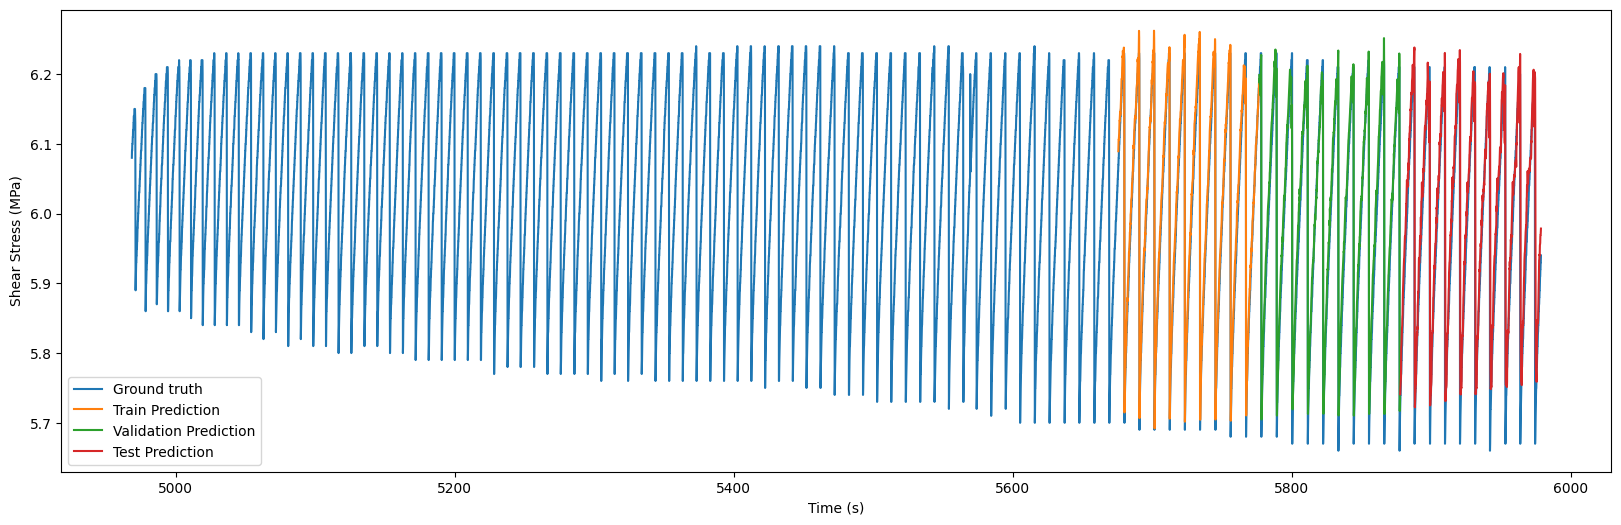

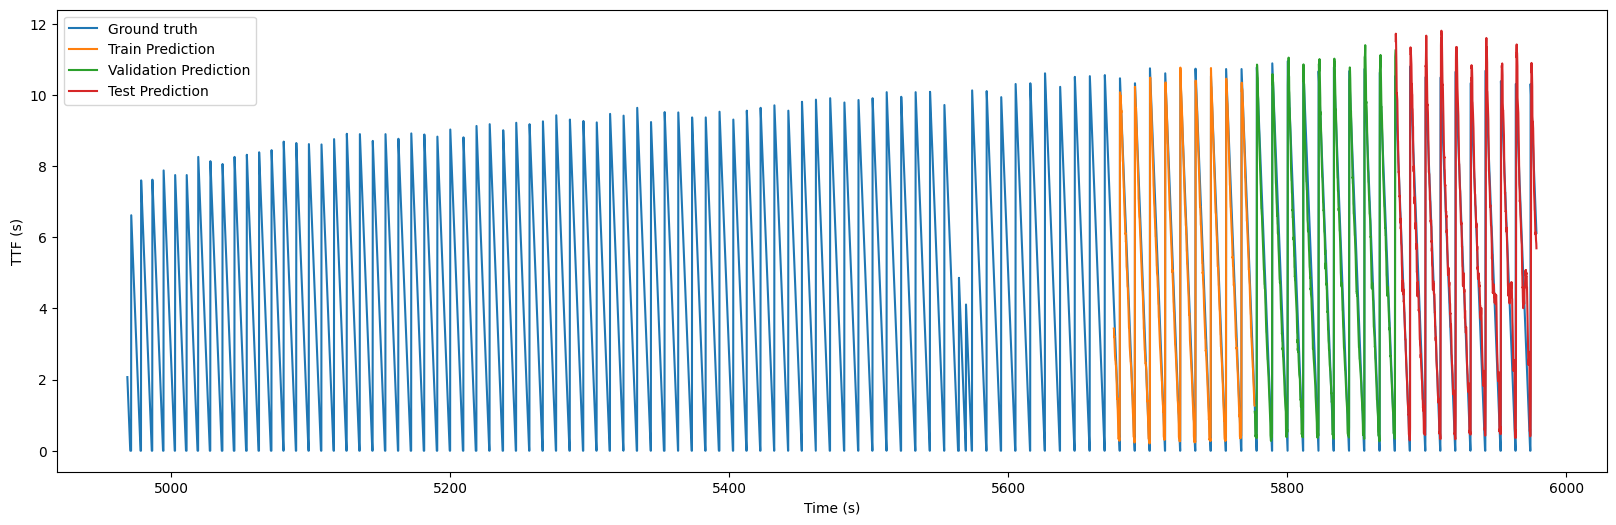

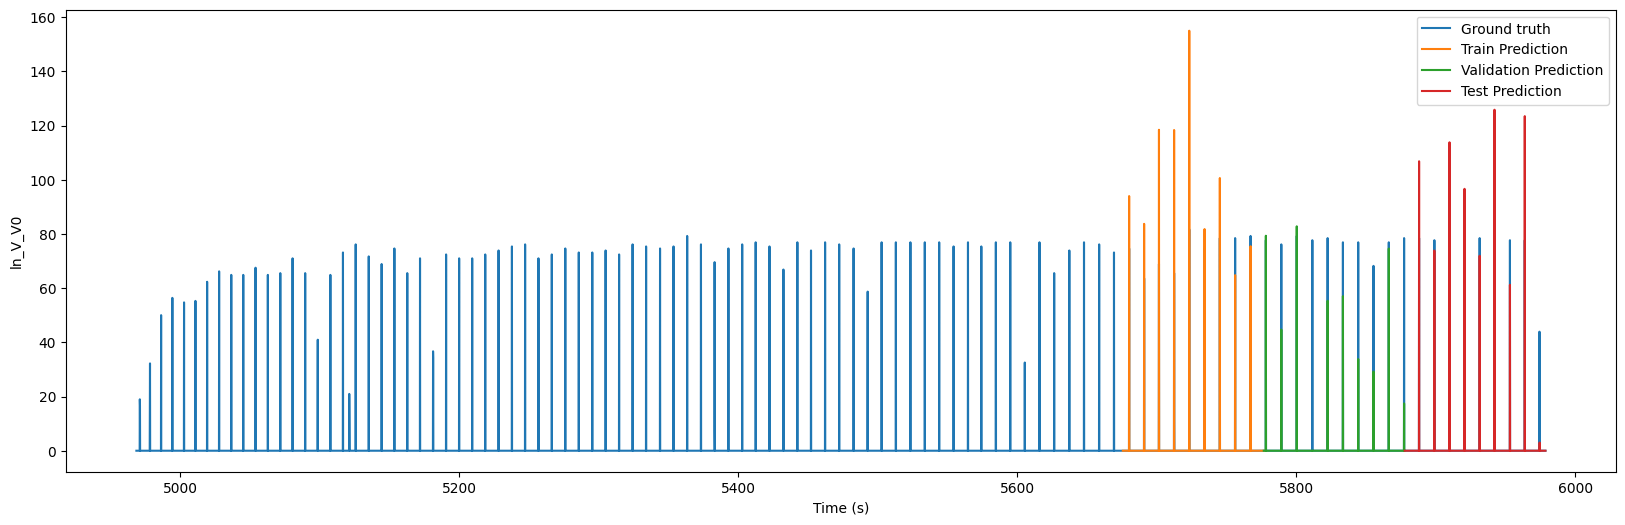

In [ ]:
# Overall plot:
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

traintime = traintime[6580:7520]

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_TTF)
plt.plot(traintime, y_predtrain_TTF)
plt.plot(valtime,  y_predval_TTF)
plt.plot(testtime, y_predtest_TTF)
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

ydf_SR = np.exp(ydf_SR)*10;
y_predtrain_SR = np.exp(y_predtrain_SR)*10;
y_predval_SR = np.exp(y_predval_SR)*10;
y_predtest_SR = np.exp(y_predtest_SR)*10;

fig = plt.figure(3, figsize=(20,6))
plt.plot(ttime, ydf_SR)
plt.plot(traintime, y_predtrain_SR)
plt.plot(valtime,  y_predval_SR)
plt.plot(testtime, y_predtest_SR)
plt.xlabel('Time (s)')
plt.ylabel('ln_V_V0')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])


In [ ]:
# Extract Weights
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

dense_7/kernel:0 (100, 128)
dense_7/bias:0 (128,)
dense/kernel:0 (400, 128)
dense/bias:0 (128,)
dense_8/kernel:0 (128, 64)
dense_8/bias:0 (64,)
dense_1/kernel:0 (128, 64)
dense_1/bias:0 (64,)
dense_9/kernel:0 (64, 32)
dense_9/bias:0 (32,)
dense_2/kernel:0 (64, 32)
dense_2/bias:0 (32,)
dense_10/kernel:0 (32, 16)
dense_10/bias:0 (16,)
dense_3/kernel:0 (32, 16)
dense_3/bias:0 (16,)
dense_11/kernel:0 (16, 8)
dense_11/bias:0 (8,)
dense_4/kernel:0 (16, 8)
dense_4/bias:0 (8,)
dense_12/kernel:0 (8, 1)
dense_12/bias:0 (1,)
dense_5/kernel:0 (8, 1)
dense_5/bias:0 (1,)
dense_6/kernel:0 (8, 1)
dense_6/bias:0 (1,)
c1:0 ()
gradient_1/dense_13/kernel:0 (1, 1)
gradient_1/dense_13/bias:0 (1,)
gradient_1/dense_14/kernel:0 (1, 1)
gradient_1/dense_14/bias:0 (1,)
gradient_1/dense_15/kernel:0 (1, 1)
gradient_1/dense_15/bias:0 (1,)


In [ ]:
# Display Weights
model.get_weights()

[array([[-0.02726281, -0.01109366, -0.01936204, ..., -0.04541412,
         -0.00103732, -0.04443521],
        [ 0.00428997,  0.01665148, -0.00114945, ...,  0.10125767,
          0.05481932,  0.06613833],
        [ 0.01365202, -0.04860995, -0.01099493, ..., -0.06564639,
         -0.11025998,  0.02772909],
        ...,
        [-0.00452229,  0.08126691, -0.03636607, ...,  0.02398663,
          0.0050219 , -0.00207343],
        [ 0.13794631,  0.19404764,  0.16434586, ...,  0.19165388,
          0.1772967 ,  0.29683927],
        [-0.17313698, -0.11973125, -0.17650591, ..., -0.16271757,
         -0.11980475, -0.2278655 ]], dtype=float32),
 array([ 0.10273919,  0.08062223,  0.1163693 ,  0.0885837 ,  0.09170812,
         0.11640348,  0.0773185 ,  0.08139834,  0.08690691,  0.05737201,
         0.08335058,  0.09497663,  0.10768039,  0.07357129,  0.06755695,
         0.05392408,  0.11305954,  0.10082231,  0.09912543,  0.08641127,
         0.08287598,  0.06423857,  0.07549904,  0.12054818,  0.111

In [ ]:
# Get scale
r1 = scaler_ss.scale_.max()
r2 = scaler_sr.scale_.max()
r3 = scaler_ae.scale_.max()
print(r1)
print(r2)
print(r3)

1.818181818181816
0.14695077149155034
0.014353380221042055
